In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
import os
import numpy as np

<img src = "images/box.png" width = "200px"/>

In [23]:
classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [2]:
import cv2 as cv
import numpy as np

def read(image_path : str, label : list):
    '''
    Returns RGB image and label matrix from local path : 
    
    Parameter
    ---------
    image_path : str
    	Local path in string 
        
    label : list
    	list of string of labels in the format : [xmin, ymin, xmax, ymax, class_idx]
    
    Returns
    -------
    	RGB 448 x 448 image,[7 x 7 x 30] label_matrix
    '''
    
    image_path = image_path.numpy()
    label = label.numpy()
    image = load_image_tf(image_path)
    #image = cv.imread(image_path)
    #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    #image = cv.resize(image, (448, 448))
    image = tf.image.resize(image, (448, 448))
    image = image / 255.
    label_matrix = np.zeros([7, 7, 30]).astype(np.float32)
    for l in label:
        l = bytes.decode(l)
        l = l.split(',')
        l = np.array(l, dtype=np.int32)
        
        xmin = l[0] / image_w * 448
        ymin = l[1] / image_h * 448
        xmax = l[2] / image_w * 448
        ymax = l[3] / image_h * 448
        class_idx = l[4]
        grid_width = 1/7
        grid_dimen = np.array([448 * grid_width, 448 * grid_width]).astype(np.int32) #grid dimensions in term of pixels x pixels
        x = (xmin + xmax) / 2  #center x of bbox
        y = (ymin + ymax) / 2  #center y of bbox
        w = (xmax - xmin)  #width of bbox
        h = (ymax - ymin)  #height of bbox
        loc = (np.array([y, x]) / grid_dimen).astype(np.int32)  # y before x as image matrix has flipped y axis
        x_new = ((x - (loc[1] * grid_dimen[0])) / grid_dimen[0]).astype(np.float16)
        y_new = ((y - (loc[0] * grid_dimen[1])) / grid_dimen[1]).astype(np.float16)
		
        #relative to grid
        #w = w / grid_dimen[0] 
        #h = h / grid_dimen[1]
        
        #relative to entire image
        w = w / image_w
        h = h / image_h
        
		#label_matrix[loc_i, loc_j, 0:20] = probability of that class present 
        #[1 = 100% that class present in the bbox[loc_i, loc_j], 0 = that class not present in bbox[loc_i, loc_j]]
        #label_matrix[loc_i, loc_j, 20] = x
        #label_matrix[loc_i, loc_j, 21] = y
        #label_matrix[loc_i, loc_j, 22] = w
        #label_matrix[loc_i, loc_j, 23] = h
        #label_matrix[loc_i, loc_j, 24] = confidence: that any object is present
        #confidence = prob of that class * IoU
        
        #YOLO-v1 contains only 2 bbox per grid....this is the info or matrix of first bbox from [.., [20, 24]]
        #similarly second bbox can be represented as [.., [25, 30]]
        #each vector contains -> [x, y, w, h, confidence]
        i = int(loc[0])
        j = int(loc[1])
        if label_matrix[i, j, 24] == 0:
            label_matrix[i, j, class_idx] = 1
            label_matrix[i, j, 20:24] = [x_new, y_new, w, h]
            label_matrix[i, j, 24] = 1  # response
    
    return [tf.cast(image, tf.float16), label_matrix.astype(np.float16)]

def load_image_tf(x) :
    #x = Full file path
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_image_cv(x) :
    #x = Full file path
    image = cv.imread(x)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

def load_file(x) :
    with open(x, 'r') as f :
        res = f.read().split(' ')
        return res[1:] #since the beginning of label file starts with space
    
def load_file_tf(x) :
    content = tf.io.read_file(x)
    content = tf.strings.split(content)
    return content

## Pre-processing
### Limit GPU memory growth
To ensure we dont have too many out of memory errors.

In [3]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data into TensorFlow Dataset

In [6]:
image_files = tf.data.Dataset.list_files(os.path.join('train', 'images', '*.jpg'), shuffle=False)

In [7]:
image_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
image_files.as_numpy_iterator().next()

b'train\\images\\000012.jpg'

In [9]:
%%time 
load_image_tf(r'train\\images\\000012.jpg').shape

CPU times: total: 0 ns
Wall time: 5 ms


TensorShape([333, 500, 3])

In [10]:
%%time 
load_image_cv(r'train\\images\\000012.jpg').shape

CPU times: total: 0 ns
Wall time: 31 ms


(333, 500, 3)

In [11]:
image_files.map(load_image_tf).as_numpy_iterator().next().shape

(333, 500, 3)

In [12]:
label_files =  tf.data.Dataset.list_files(os.path.join('train', 'labels', '*.txt'), shuffle=False)

In [13]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
label_files.as_numpy_iterator().next()

b'train\\labels\\000012.txt'

In [15]:
%%time
load_file('train\\labels\\000017.txt')

CPU times: total: 0 ns
Wall time: 999 µs


['185,62,279,199,14', '90,78,403,336,12']

In [16]:
%%time
load_file_tf('train\\labels\\000017.txt')

CPU times: total: 62.5 ms
Wall time: 45 ms


<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'185,62,279,199,14', b'90,78,403,336,12'], dtype=object)>

In [17]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [18]:
label_files_mapped = label_files.map(load_file_tf)

In [19]:
label_files_generator = label_files_mapped.as_numpy_iterator()

In [20]:
print(label_files_generator.next())
print(label_files_generator.next())

[b'156,97,351,270,6']
[b'185,62,279,199,14' b'90,78,403,336,12']


In [21]:
image_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [22]:
label_files_mapped

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [23]:
zipped = tf.data.Dataset.zip((image_files, label_files_mapped))
zipped_generator = zipped.as_numpy_iterator()

In [24]:
print(zipped_generator.next())
print(zipped_generator.next())

(b'train\\images\\000012.jpg', array([b'156,97,351,270,6'], dtype=object))
(b'train\\images\\000017.jpg', array([b'185,62,279,199,14', b'90,78,403,336,12'], dtype=object))


In [25]:
len(list(zipped))

2501

In [26]:
org_data = zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float32, tf.uint8]))
org_data_generator = org_data.as_numpy_iterator()

In [27]:
print(org_data_generator.next()[0].shape , org_data_generator.next()[1].shape, sep = '\n')

(448, 448, 3)
(7, 7, 30)


### Load data as partitioned dataset in correct format

In [5]:
batch_size = 2

In [6]:
images = tf.data.Dataset.list_files(os.path.join('train', 'images', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('train', 'labels', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
train = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float16, tf.float16]))
train = train.shuffle(10000)
train = train.batch(batch_size)
train = train.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(train))

Lenth =  1251


In [7]:
#!!!!!very expensive step (because of batch size with a prefetch)
#print(train.as_numpy_iterator().next()[0].shape , train.as_numpy_iterator().next()[1].shape, sep = '\n')

In [8]:
images = tf.data.Dataset.list_files(os.path.join('test', 'images', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('test', 'labels', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
test = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float16, tf.float16]))
test = test.shuffle(5000)
test = test.batch(batch_size)
test = test.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(test))

Lenth =  2476


In [9]:
images = tf.data.Dataset.list_files(os.path.join('val', 'images', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('val', 'labels', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
val = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float16, tf.float16]))
val = val.shuffle(5000)
val = val.batch(batch_size)
val = val.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(val))

Lenth =  1255


## View Images and Annotations

In [35]:
data_samples_gen = val.as_numpy_iterator()

In [36]:
res = data_samples_gen.next()
start = 0

In [37]:
res[0].shape

(4, 448, 448, 3)

In [38]:
res[1].shape

(4, 7, 7, 30)

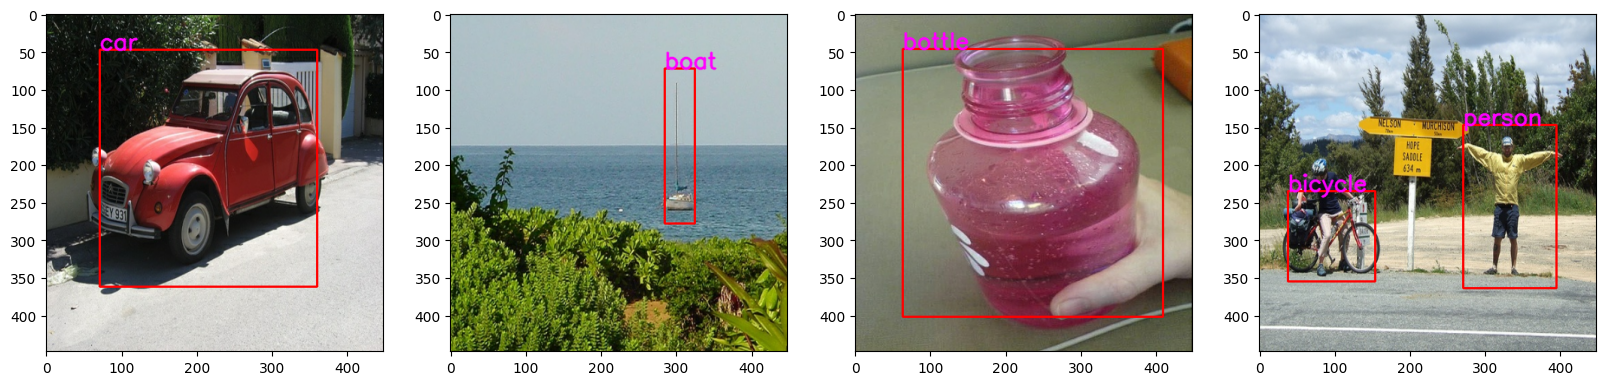

In [39]:
confidence_thresh = 0.5
grid_width = 1 / 7
grid_dimen = np.array([448 * grid_width, 448 * grid_width]).astype(np.int32)
list_classes = list(classes_num)
plots = 4
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx] * 255).astype(np.uint8)
    
    for i in range(7) :
        for j in range(7) :
            if res[1][idx, i, j, 24] < confidence_thresh: continue 
            sample_coords = res[1][idx,i, j, 20:24] #[x, y, w, h]
            grid_width = 1/7
            
            #width = sample_coords[2] * grid_dimen[0] 
            #height = sample_coords[3] * grid_dimen[1]
            width = sample_coords[2] * 448
            height = sample_coords[3] * 448
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[int(res[1][idx, i, j, :20].argmax())],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =2,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()

## YOLO model - Architecture
![image.png](attachment:31464247-feea-4dc1-9248-71b4482121f1.png)

### Defining a custom output layer
We need to reshape the output from the model so we define a custom Keras layer for it.

In [10]:
from tensorflow import keras
import keras.backend as K

class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        super(Yolo_Reshape, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input):
        # grids 7x7
        S = [self.target_shape[0], self.target_shape[1]]
        # classes
        C = 20
        # no of bounding boxes per grid
        B = 2

        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B

        # class probabilities
        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
        class_probs = K.softmax(class_probs)

        #confidence
        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs)

        # boxes
        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)

        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs

### Building model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,30)))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 192)     110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 192)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     24704     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 256)     2

### Define a custom learning rate scheduler
The paper uses different learning rates for different epochs. So we define a custom Callback function for the learning rate.

In [13]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1e-4),
    (3, 1e-5),
    (100, 1e-6),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

### Define the loss function

In [14]:
def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448
    
    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1
    
    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss
    return loss

### Adding a callback for saving the weights

In [15]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

### Compile the model
Finally, compile the model using the custom loss function that was defined above.

In [16]:
model.compile(loss=yolo_loss ,optimizer='adam')

In [17]:
?model.fit_generator

Signature:
model.fit_generator(
    generator,
    steps_per_epoch=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_data=None,
    validation_steps=None,
    validation_freq=1,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0,
)
Docstring:
Fits the model on data yielded batch-by-batch by a Python generator.

DEPRECATED:
  `Model.fit` now supports generators, so there is no longer any need to
  use this endpoint.
File:      c:\users\dhruv\desktop\env\venv\lib\site-packages\keras\engine\training.py
Type:      method


In [17]:
hist = model.fit_generator(generator = train, 
          epochs = 5,
          verbose = 1,
          workers= 4,
          validation_data = val,
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save
          ])


Epoch 00000: Learning rate is 0.0001.
Epoch 1/5


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_7916\1630939645.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator = train,


1251/1251 [==============================] - 470s 333ms/step - loss: 30.9188 - val_loss: 30.5721

Epoch 00001: Learning rate is 0.0001.
Epoch 2/5
1251/1251 [==============================] - 434s 327ms/step - loss: 31.2795 - val_loss: 30.6547

Epoch 00002: Learning rate is 0.0001.
Epoch 3/5
1251/1251 [==============================] - 426s 322ms/step - loss: 31.6991 - val_loss: 30.6547

Epoch 00003: Learning rate is 0.0000.
Epoch 4/5
1251/1251 [==============================] - 429s 325ms/step - loss: 31.6959 - val_loss: 30.6330

Epoch 00004: Learning rate is 0.0000.
Epoch 5/5
1251/1251 [==============================] - 468s 354ms/step - loss: 31.6664 - val_loss: 30.6330


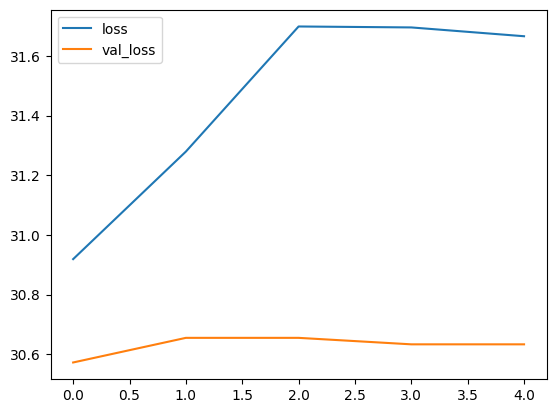

In [18]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend()

In [ ]:
hist = model.fit(x=train,
          steps_per_epoch = int(len(train) // batch_size),
          batch_size=batch_size,
          epochs = 200,
          verbose = 1,
          workers= 4,
          validation_data = val,
          validation_steps = int(len(val) // batch_size),
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save
          ])

In [12]:
model.load_weights('weight.hdf5')

In [19]:
a = test.as_numpy_iterator().next()

In [20]:
#model.compile(loss=yolo_loss ,optimizer='adam')
eval_ = model.predict(a[0])

1/1 [==============================] - 1s 513ms/step


In [21]:
res = (a[0], eval_)

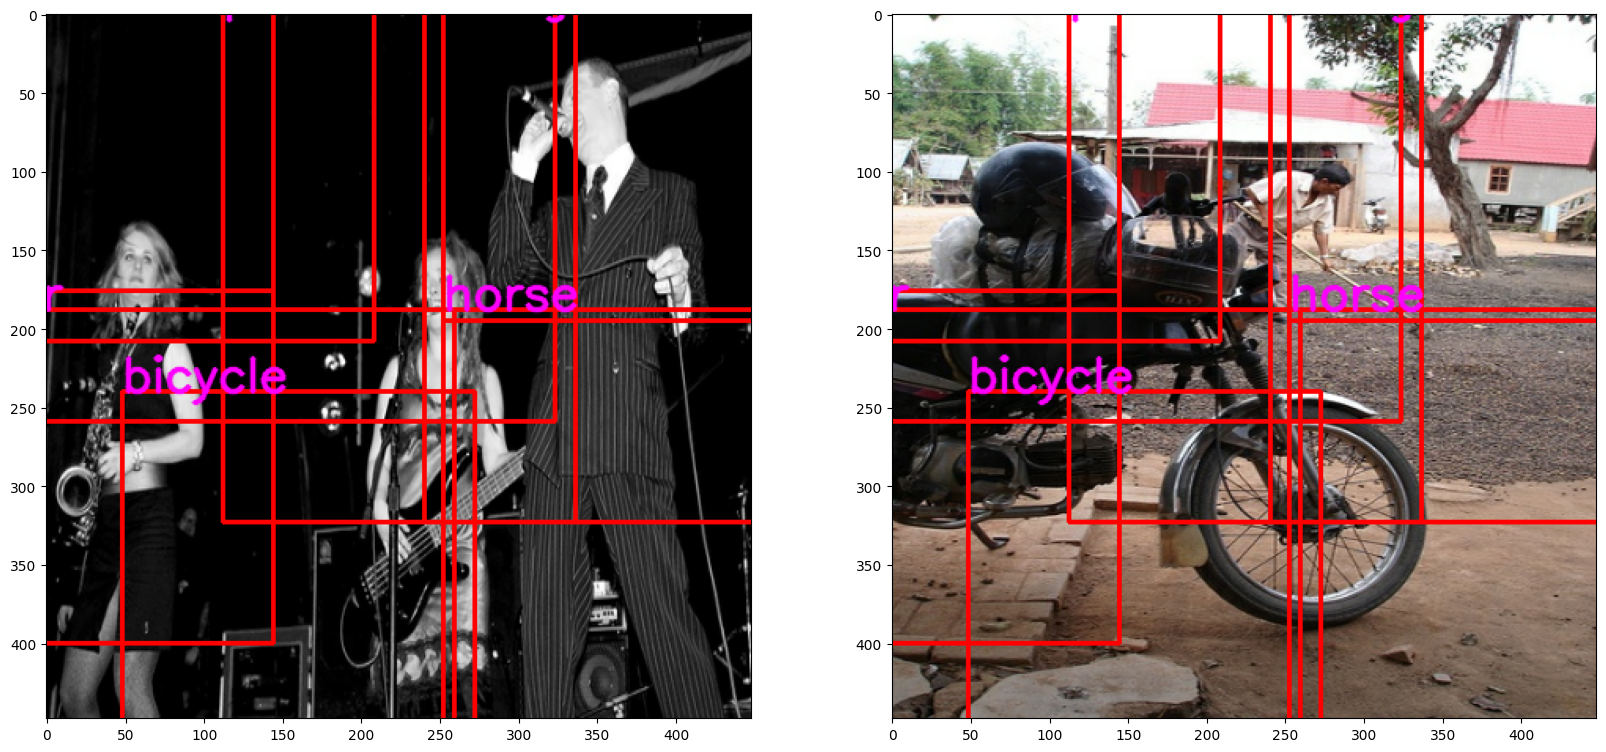

In [28]:
confidence_thresh = 0.73
grid_width = 1 / 7
grid_dimen = np.array([448 * grid_width, 448 * grid_width]).astype(np.int32)
list_classes = list(classes_num)
plots = 2
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx] * 255).astype(np.uint8)
    
    for i in range(7) :
        for j in range(7) :
            if res[1][idx, i, j, 24] < confidence_thresh: continue 
            sample_coords = res[1][idx,i, j, 20:24] #[x, y, w, h]
            grid_width = 1/7
            
            #width = sample_coords[2] * grid_dimen[0] 
            #height = sample_coords[3] * grid_dimen[1]
            width = sample_coords[2] * 448
            height = sample_coords[3] * 448
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[int(res[1][idx, i, j, :20].argmax())],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =2,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()